# Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import spacy

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

# Load data

In [2]:
file_path = "../data/processed/dataset_space_mission.csv"

df = pd.read_csv(file_path)

display(df.sample(5))
print(df.info())
display(df.describe())

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,Year,Decade
2318,RVSN USSR,"Site 107/1, Kapustin Yar, Russia",1982-07-29 19:40:00,Cosmos-3M (11K65M) | Cosmos 1397,StatusRetired,62.0,Success,1982,1980
1130,MHI,"LA-Y1, Tanegashima Space Center, Japan",2001-08-29 07:00:00,H-IIA 202 | VEP 2 & LRE,StatusActive,90.0,Success,2001,2000
3430,RVSN USSR,"Site 161/35, Baikonur Cosmodrome, Kazakhstan",1970-09-25 14:05:00,Tsyklon | Cosmos 365,StatusRetired,62.0,Success,1970,1970
123,Roscosmos,"Site 81/24, Baikonur Cosmodrome, Kazakhstan",2019-07-13 12:31:00,Proton-M/DM-3 | Spektr-RG,StatusActive,65.0,Success,2019,2010
4302,US Navy,"Douglas F4D Skyray, Naval Air Station Point Mu...",1958-08-29 00:00:00,NOTS-EV-1 Pilot II | Pilot-6 (R3,StatusRetired,62.0,Failure,1958,1950


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company Name    4324 non-null   object 
 1   Location        4324 non-null   object 
 2   Datum           4324 non-null   object 
 3   Detail          4324 non-null   object 
 4   Status Rocket   4324 non-null   object 
 5    Rocket         4324 non-null   float64
 6   Status Mission  4324 non-null   object 
 7   Year            4324 non-null   int64  
 8   Decade          4324 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 304.2+ KB
None


,Rocket,Year,Decade
count,4324.000000,4324.000000,4324.000000
mean,76.879204,1987.386679,1982.680389
std,72.702577,18.072562,17.925194
min,5.300000,1957.000000,1950.000000
25%,62.000000,1972.000000,1970.000000
50%,62.000000,1984.000000,1980.000000
75%,62.000000,2002.000000,2000.000000
max,450.000000,2020.000000,2020.000000


# NLP Preprocessing

## Combine text fields

In [3]:
df['text_features'] = df['Company Name'] + " " + df['Detail'] + " " + df['Location']

display(df[['text_features', 'Status Mission']].sample(5))

,text_features,Status Mission
461,"KCST Unha-3 | Kwangmyngsng-4 Pad 1, Sohae ...",Success
366,"SpaceX Falcon 9 Block 3 | Echostar 23 LC-39A, ...",Success
1209,"ILS Atlas IIAS | Hispasat 1C SLC-36B, Cape Can...",Success
1405,"NASA Space Shuttle Discovery | STS-82 LC-39A, ...",Success
3446,RVSN USSR Cosmos-2I (63SM) | Intercosmos-3 Sit...,Success


## Encoding Target

In [4]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['Status Mission'])

## Splitting dataset into train/test sets

In [5]:
X = df[['text_features', ' Rocket', 'Status Rocket', 'Decade']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Wrapper around clean_text_array function

The text_features column contains technical terms, acronyms, numbers, and mission IDs (e.g., "STS-9", "Cosmos-3M",...). In this context, semantic context matters less, but preserving the structure of these tokens is crucial for accurate prediction.

Using spaCy’s lemmatizer is preferable over NLTK’s because it is robust and context-aware: it automatically applies POS tagging to avoid lemmatization mistakes, handles mixed tokens and keeps numbers, hyphens, and acronyms intact. This ensures the framework extracts meaningful textual features without losing technical information, making the model more accurate and reliable.

In [6]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text_array(texts):
    cleaned_texts = []
    for text in texts:
        if not isinstance(text, str):
            text = ""
        text = text.lower()
        text = re.sub(r"[^a-z0-9\-\s/]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc 
                  if token.is_alpha or token.text.isdigit() or "-" in token.text]
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

# Wrapping in a FunctionTransformer so it can turn my clean_text_array function into a transformer
# (objects that have fit() and transform() methods)
text_cleaner = FunctionTransformer(clean_text_array, validate=False)

## Vectorization and Feature Engineering

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('clean', text_cleaner),
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)))
        ]), 'text_features'),
        ('num', StandardScaler(), [' Rocket']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Status Rocket', 'Decade'])
    ]
)


# Machine Learning Model

## Pipeline

In [8]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Evaluation

In [12]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                    precision    recall  f1-score   support

          Failure       0.35      0.57      0.44        68
  Partial Failure       0.04      0.30      0.07        20
Prelaunch Failure       0.00      0.00      0.00         1
          Success       0.94      0.74      0.83       776

         accuracy                           0.72       865
        macro avg       0.33      0.40      0.34       865
     weighted avg       0.87      0.72      0.78       865



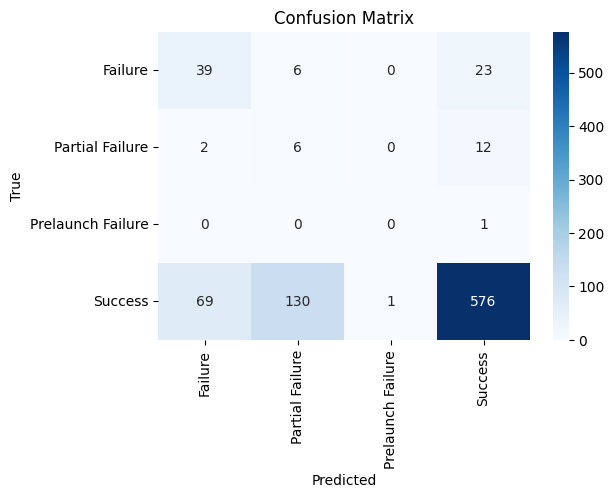

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

In [18]:
import numpy as np

model = pipeline.named_steps['classifier']
vectorizer = pipeline.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

# For multi-class
for class_idx, class_name in enumerate(le.classes_):
    coefs = model.coef_[class_idx]
    
    # Get indices of top 10 features safely
    top_pos_idx = np.argsort(coefs)[-10:][::-1]  # largest 10 coefficients
    top_features = [(feature_names[i], coefs[i]) for i in top_pos_idx if i < len(feature_names)]
    
    print(f"\nTop predictive words for class '{class_name}':")
    for word, coef in top_features:
        print(f"{word}: {coef:.3f}")



Top predictive words for class 'Failure':
zenit: 2.153
ds: 2.145
voskhod zenit: 1.625
2i ds: 1.575
unknown: 1.238
unknown payload: 1.238
payload imam: 1.238
payload: 1.238
cosmos strela: 1.218
luna: 1.193

Top predictive words for class 'Partial Failure':
cosmos: 2.148
nvl cosmos: 1.827
chinasat lc: 1.788
2b ela: 1.768
ml cosmos: 1.748
molniya nvl: 1.587
nvl: 1.587
to 1235: 1.535
bsat: 1.482

Top predictive words for class 'Prelaunch Failure':
soyuz ok: 4.449
soyuz: 3.023
soyuz soyuz: 2.583
safir 1b: 1.865
ussr soyuz: 1.730
vls: 1.714
safir: 1.663
isa safir: 1.663
1b: 1.639

Top predictive words for class 'Success':
cosmos: 1.512
ml molniya: 1.441
2i cosmos: 1.429
molniya: 1.199
cosmos 2i: 1.007
2i: 1.007
voskhod cosmos: 0.967
vostok: 0.961
iia: 0.898
vostok cosmos: 0.888
